In [53]:
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import quandl 
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

In [54]:
data = pd.read_csv("global_co2.csv")

Найдем год в котором стали считать данные загрязнения на душу населения. 

In [55]:
data_with_per_capita = data[data["Per Capita"] >= 0.]

In [56]:
data_with_per_capita.head()

,Year,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita
199,1950,1630,97,423,1070,18,23,0.64
200,1951,1767,115,479,1129,20,24,0.69
201,1952,1795,124,504,1119,22,26,0.68
202,1953,1841,131,533,1125,24,27,0.69
203,1954,1865,138,557,1116,27,27,0.69


Так, с 1950 года стали учитывать показания на население. Мы не можем предсказывать прошлое по будущему, поэтому не будем трогать данные ранее 1950 и будем работать только с этими данными. 

In [59]:
data_with_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 199 to 259
Data columns (total 8 columns):
Year           61 non-null int64
Total          61 non-null int64
Gas Fuel       61 non-null int64
Liquid Fuel    61 non-null int64
Solid Fuel     61 non-null int64
Cement         61 non-null int64
Gas Flaring    61 non-null int64
Per Capita     61 non-null float64
dtypes: float64(1), int64(7)
memory usage: 4.3 KB


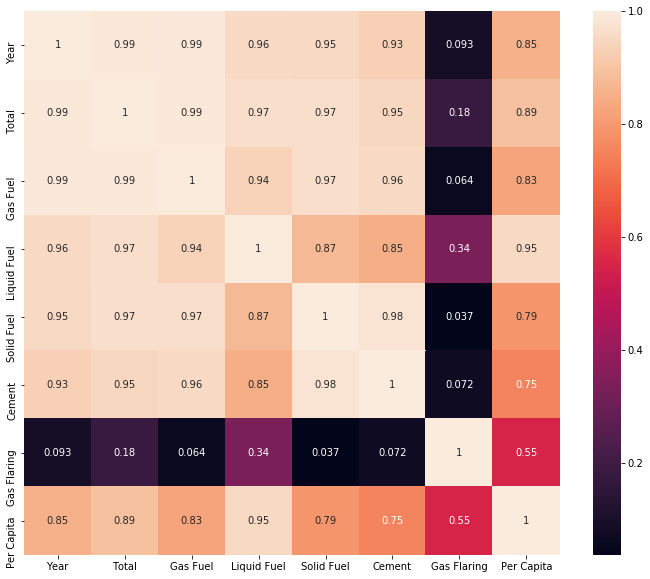

In [60]:
sns.heatmap(data_with_per_capita.corr(), annot=True);

Заметим, что мы не можем учитывать показатель суммы и год.
Год при создании линейной регрессии будет учитываться как численный показатель, но из соображений логики ясно, что год не будет уменьшаться или как-то изменяться в меньшую сторону.

Проверим показатель Total. Судя по коррелляционной матрице, он является суммой показателей-загрязнителей.

In [61]:
print(all (data_with_per_capita["Total"]==data_with_per_capita["Gas Fuel"]+
         data_with_per_capita["Liquid Fuel"]+
         data_with_per_capita["Solid Fuel"]+
         data_with_per_capita["Cement"]+
         data_with_per_capita["Gas Flaring"]))

False


Показатель не является суммой показателей-загрязнителей, может быть тут хитрее зависимость? Простым перебором получаем, что Total отличается от суммы показателей-загрязнителей максимум на 2 ед.

In [62]:
print(all (abs(data_with_per_capita["Total"]-(data_with_per_capita["Gas Fuel"]+
         data_with_per_capita["Liquid Fuel"]+
         data_with_per_capita["Solid Fuel"]+
         data_with_per_capita["Cement"]+
         data_with_per_capita["Gas Flaring"]) ) <=2 ))

True


То есть можно сказать, что $Total = ["Gas Fuel"] + ["Liquid Fuel"]+["Solid Fuel"]+["Cement"]+["Gas Flaring"] + bias $. 

Где $bias \in(-2,-1,0,1)$

То есть мы можем получить смещенную оценку, если выкинем Total из рассмотрения. Но если мы его примем к рассмотрению, то по 2 раза учтем показатели-загрязнители. 

Решим эту проблему, внедря новый столбец $bias$

In [63]:
data_with_per_capita['bias'] = data_with_per_capita["Total"]-(data_with_per_capita["Gas Fuel"]+
         data_with_per_capita["Liquid Fuel"]+
         data_with_per_capita["Solid Fuel"]+
         data_with_per_capita["Cement"]+
         data_with_per_capita["Gas Flaring"])

d:\programs\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [64]:
data_with_per_capita.head()

,Year,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita,bias
199,1950,1630,97,423,1070,18,23,0.64,-1
200,1951,1767,115,479,1129,20,24,0.69,0
201,1952,1795,124,504,1119,22,26,0.68,0
202,1953,1841,131,533,1125,24,27,0.69,1
203,1954,1865,138,557,1116,27,27,0.69,0


In [65]:
data_with_per_capita.describe()

,Year,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita,bias
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,1980.000000,4984.114754,769.327869,2005.229508,2012.081967,141.901639,55.688525,1.054754,-0.114754
std,17.752934,2070.838720,474.350599,850.674054,696.221907,106.848289,23.983009,0.178630,0.709421
min,1950.000000,1630.000000,97.000000,423.000000,1070.000000,18.000000,23.000000,0.640000,-2.000000
25%,1965.000000,3130.000000,337.000000,1219.000000,1448.000000,59.000000,37.000000,0.940000,-1.000000
50%,1980.000000,5113.000000,740.000000,2289.000000,1921.000000,120.000000,48.000000,1.120000,0.000000
75%,1995.000000,6398.000000,1157.000000,2605.000000,2414.000000,197.000000,66.000000,1.170000,0.000000
max,2010.000000,9167.000000,1702.000000,3122.000000,3842.000000,450.000000,110.000000,1.330000,1.000000


In [66]:
features = [c for c in data_with_per_capita.columns if c != "Per Capita" and c != "Total" and c != "Year"]

In [67]:
features

['Gas Fuel', 'Liquid Fuel', 'Solid Fuel', 'Cement', 'Gas Flaring', 'bias']

In [68]:
target = "Per Capita"
X = data_with_per_capita[features]
y = data_with_per_capita[target]


Разделим данный датасет на тренировочный и валидационный на $70%$ и $30%$ соответственно. 

$61\cdot 0.7 \approx 42$

In [69]:
X_train, X_test, y_train, y_test = X[:42],X[42:],y[:42],y[42:]

Теперь можем смело строить линейную регрессию после подготовки данных. Мы знаем, что у нас в валидационной выборке лежат данные "старше", чем в тренировочной.

In [70]:
lin = LinearRegression()

In [71]:
lin.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [72]:
for i,k in enumerate(features):
    print(k ,":",lin.coef_[i])
    

Gas Fuel : 0.000128988933065
Liquid Fuel : 0.00010505523122
Solid Fuel : 0.000334215728543
Cement : -0.00259849331617
Gas Flaring : 0.00323188306788
bias : 0.00272864075557


In [73]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)*100

Проверим возможность переобучения и качество нашей модели с помощью MAPE - оценки

In [74]:
pred_train = lin.predict(X_train)

In [75]:
print("MAPE train = %.2f" % mean_absolute_percentage_error(y_train,pred_train),"%",sep='')

MAPE train = 1.46%


In [76]:
pred_test = lin.predict(X_test)


In [77]:
print("MAPE train = %.2f" % mean_absolute_percentage_error(y_test,pred_test),"%",sep='')

MAPE train = 6.86%


In [78]:
pred =np.concatenate([pred_train,pred_test])


Визуализируем данные: "процент загрязнения" в зависимости от общего количества выброшенного мусора

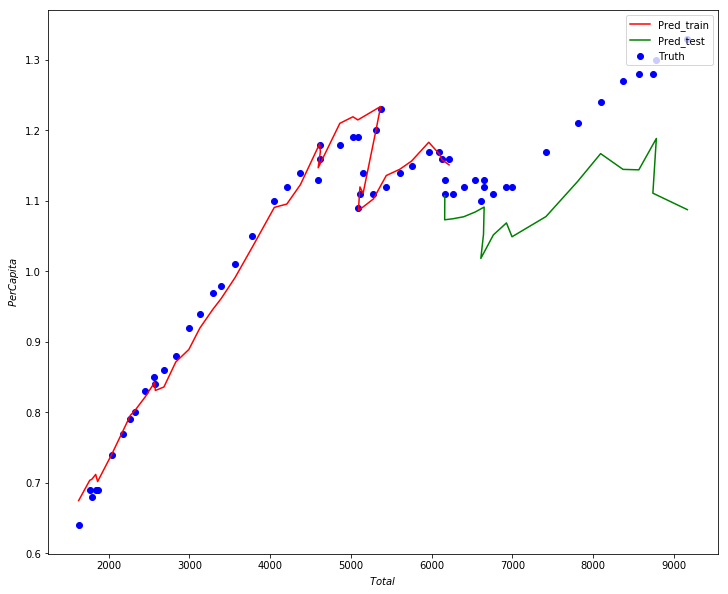

In [85]:
plt.scatter(data_with_per_capita["Total"], y, color = 'blue',
            label = "Truth")
plt.plot(data_with_per_capita["Total"][:42], pred_train, color = 'red',
            label = "Pred_train")
plt.plot(data_with_per_capita["Total"][42:], pred_test, color = 'green',
            label = "Pred_test")

plt.xlabel(r"$Total$") 
plt.ylabel(r"$Per Capita$") # Label for y-axis.
plt.legend(loc = 'upper right') # loc stands for 'location' of legend
plt.show();

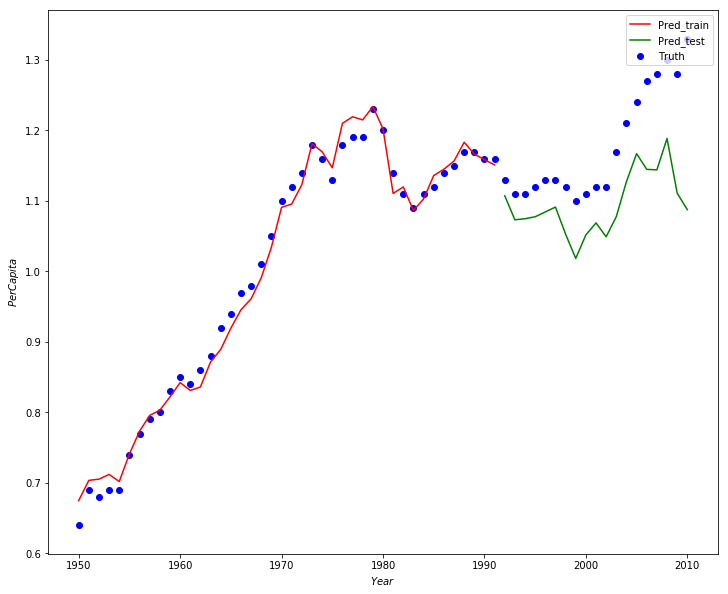

In [86]:
plt.scatter(data_with_per_capita["Year"], y, color = 'blue',
            label = "Truth")
plt.plot(data_with_per_capita["Year"][:42], pred_train, color = 'red',
            label = "Pred_train")
plt.plot(data_with_per_capita["Year"][42:], pred_test, color = 'green',
            label = "Pred_test")

plt.xlabel(r"$Year$") 
plt.ylabel(r"$Per Capita$") # Label for y-axis.
plt.legend(loc = 'upper right') # loc stands for 'location' of legend
plt.show();

Из графиков явно видно, что наша регрессия переобучилась на тестовых данных, и уже не смогла спрогнозировать данные будущего.


Вывод: из-за нехватки данных модель не смогла точно предсказать значения и переобучилась
